In [ ]:
!pip install numpy opencv-python pillow tensorflow keras imutils scikit-learn matplotlib kagglehub


in

In [ ]:
import kagglehub
import os
# Download latest version
path = kagglehub.dataset_download("paultimothymooney/breast-histopathology-images")

print("Path to dataset files:", path)

INPUT_DATASET = path # 'path' now holds the location of the downloaded dataset
BASE_PATH = "datasets/idc"
TRAIN_PATH = os.path.sep.join([BASE_PATH, "training"])
VAL_PATH = os.path.sep.join([BASE_PATH, "validation"])
TEST_PATH = os.path.sep.join([BASE_PATH, "testing"])

# Define splits
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1

# Now you can use these paths to access your data
print(f"Input dataset path: {INPUT_DATASET}")
print(f"Base path: {BASE_PATH}")
print(f"Training path: {TRAIN_PATH}")
print(f"Validation path: {VAL_PATH}")
print(f"Testing path: {TEST_PATH}")
print(f"Train split: {TRAIN_SPLIT}")
print(f"Validation split: {VAL_SPLIT}")

100%|██████████| 3.10G/3.10G [00:24<00:00, 137MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/breast-histopathology-images/versions/1
Input dataset path: /root/.cache/kagglehub/datasets/paultimothymooney/breast-histopathology-images/versions/1
Base path: datasets/idc
Training path: datasets/idc/training
Validation path: datasets/idc/validation
Testing path: datasets/idc/testing
Train split: 0.8
Validation split: 0.1


In [ ]:
from imutils import paths
import random, shutil, os

# Define the variables directly, as they were already set
# INPUT_DATASET, TRAIN_SPLIT, VAL_SPLIT, TRAIN_PATH, VAL_PATH, TEST_PATH are defined earlier
# from cancernet import config # Remove this line

originalPaths=list(paths.list_images(INPUT_DATASET)) # Use the local variable
random.seed(7)
random.shuffle(originalPaths)
index=int(len(originalPaths)*TRAIN_SPLIT) # Use the local variable
trainPaths=originalPaths[:index]
testPaths=originalPaths[index:]
index=int(len(trainPaths)*VAL_SPLIT) # Use the local variable
valPaths=trainPaths[:index]
trainPaths=trainPaths[index:]

datasets=[("training", trainPaths, TRAIN_PATH), # Use the local variables
          ("validation", valPaths, VAL_PATH),     # Use the local variables
          ("testing", testPaths, TEST_PATH)       # Use the local variables
]

for (setType, originalPaths, basePath) in datasets:
        print(f'Building {setType} set')
        if not os.path.exists(basePath):
                # Correct the variable name from base_path to basePath
                print(f'Building directory {basePath}')
                os.makedirs(basePath)
        for path in originalPaths:
                file=path.split(os.path.sep)[-1]
                label=file[-5:-4]
                labelPath=os.path.sep.join([basePath,label])
                if not os.path.exists(labelPath):
                        print(f'Building directory {labelPath}')
                        os.makedirs(labelPath)
                newPath=os.path.sep.join([labelPath, file])
                # Correct the variable name from inputPath to path
                shutil.copy2(path, newPath)

Building training set
Building directory datasets/idc/training
Building directory datasets/idc/training/0
Building directory datasets/idc/training/1
Building validation set
Building directory datasets/idc/validation
Building directory datasets/idc/validation/0
Building directory datasets/idc/validation/1
Building testing set
Building directory datasets/idc/testing
Building directory datasets/idc/testing/1
Building directory datasets/idc/testing/0


In [ ]:
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import SeparableConv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
from keras import backend as K

class CancerNet:
  @staticmethod
  def build(width,height,depth,classes):
    model=Sequential()
    shape=(height,width,depth)
    channelDim=-1
    if K.image_data_format()=="channels_first":
      shape=(depth,height,width)
      channelDim=1
    model.add(SeparableConv2D(32, (3,3), padding="same",input_shape=shape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=channelDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(SeparableConv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=channelDim))
    model.add(SeparableConv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=channelDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(SeparableConv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=channelDim))
    model.add(SeparableConv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=channelDim))
    model.add(SeparableConv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=channelDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(classes))
    model.add(Activation("softmax"))
    return model



In [ ]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import Adagrad
from tensorflow.keras.utils import to_categorical
#from keras.utils import np_utils
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
#from cancernet.cancernet import CancerNet
#from cancernet import config
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os


NUM_EPOCHS=40; INIT_LR=1e-2; BS=32

trainPaths=list(paths.list_images(TRAIN_PATH))
lenTrain=len(trainPaths)
lenVal=len(list(paths.list_images(VAL_PATH)))
lenTest=len(list(paths.list_images(TEST_PATH)))

trainLabels=[int(p.split(os.path.sep)[-2]) for p in trainPaths]
trainLabels=to_categorical(trainLabels)
#trainLabels=np_utils.to_categorical(trainLabels)


classTotals=trainLabels.sum(axis=0)
# classWeight=classTotals.max()/classTotals # This produces a numpy array

# Convert the class weights to a dictionary
classWeight = {0: classTotals.max() / classTotals[0], 1: classTotals.max() / classTotals[1]}


trainAug = ImageDataGenerator(
  rescale=1/255.0,
  rotation_range=20,
  zoom_range=0.05,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.05,
  horizontal_flip=True,
  vertical_flip=True,
  fill_mode="nearest")

valAug=ImageDataGenerator(rescale=1 / 255.0)

trainGen = trainAug.flow_from_directory(
  TRAIN_PATH,
  class_mode="categorical",
  target_size=(48,48),
  color_mode="rgb",
  shuffle=True,
  batch_size=BS)

valGen = valAug.flow_from_directory(
  VAL_PATH,
  class_mode="categorical",
  target_size=(48,48),
  color_mode="rgb",
  shuffle=False,
  batch_size=BS)

testGen = valAug.flow_from_directory(
  TEST_PATH,
  class_mode="categorical",
  target_size=(48,48),
  color_mode="rgb",
  shuffle=False,
  batch_size=BS)

model=CancerNet.build(width=48,height=48,depth=3,classes=2)

#opt=Adagrad(lr=INIT_LR,decay=INIT_LR/NUM_EPOCHS)
opt=Adagrad(learning_rate=INIT_LR)

model.compile(loss="binary_crossentropy",optimizer=opt,metrics=["accuracy"])

M = model.fit(
    trainGen,
    steps_per_epoch=lenTrain // BS,
    validation_data=valGen,
    validation_steps=lenVal // BS,
    class_weight=classWeight,
    epochs=NUM_EPOCHS
)

print("Now evaluating the model")
testGen.reset()
#pred_indices=model.predict_generator(testGen,steps=(lenTest//BS)+1)
pred_indices=model.predict(testGen)
pred_indices=np.argmax(pred_indices,axis=1)

print(classification_report(testGen.classes, pred_indices, target_names=testGen.class_indices.keys()))
cm=confusion_matrix(testGen.classes,pred_indices)
total=sum(sum(cm))
accuracy=(cm[0,0]+cm[1,1])/total

specificity=cm[1,1]/(cm[1,0]+cm[1,1])
sensitivity=cm[0,0]/(cm[0,0]+cm[0,1])

print(cm)
print(f'Accuracy: {accuracy}')
print(f'Specificity: {specificity}')
print(f'Sensitivity: {sensitivity}')
N = NUM_EPOCHS

Found 255635 images belonging to 2 classes.
Found 42579 images belonging to 2 classes.
Found 99899 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_separable_conv.py:104: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
7988/7988 ━━━━━━━━━━━━━━━━━━━━ 560s 69ms/step - accuracy: 0.7999 - loss: 0.6536 - val_accuracy: 0.7902 - val_loss: 0.5157
Epoch 2/40
   1/7988 ━━━━━━━━━━━━━━━━━━━━ 1:42 13ms/step - accuracy: 0.7812 - loss: 0.5713

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


7988/7988 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.7812 - loss: 0.5713 - val_accuracy: 0.8238 - val_loss: 0.4420
Epoch 3/40
7988/7988 ━━━━━━━━━━━━━━━━━━━━ 502s 57ms/step - accuracy: 0.8312 - loss: 0.5501 - val_accuracy: 0.7684 - val_loss: 0.5165
Epoch 4/40
7988/7988 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.8125 - loss: 0.5166 - val_accuracy: 0.7677 - val_loss: 0.5202
Epoch 5/40
7988/7988 ━━━━━━━━━━━━━━━━━━━━ 359s 45ms/step - accuracy: 0.8400 - loss: 0.5313 - val_accuracy: 0.6822 - val_loss: 0.6648
Epoch 6/40
7988/7988 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.9062 - loss: 0.3592 - val_accuracy: 0.6911 - val_loss: 0.6457
Epoch 7/40
7988/7988 ━━━━━━━━━━━━━━━━━━━━ 383s 48ms/step - accuracy: 0.8407 - loss: 0.5218 - val_accuracy: 0.8432 - val_loss: 0.3685
Epoch 8/40
7988/7988 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.7500 - loss: 0.6553 - val_accuracy: 0.8369 - val_loss: 0.3944
Epoch 9/40
7988/7988 ━━━━━━━━━━━━━━━━━━━━ 442s 50ms/step - accuracy: 0.8465 - loss: 0.51

In [ ]:
tn, fp, fn, tp = cm.ravel()

sensitivity = tp / (tp + fn)  # True positive rate / Recall
specificity = tn / (tn + fp)  # True negative rate

print(f'Sensitivity (Recall): {sensitivity:.4f}')
print(f'Specificity: {specificity:.4f}')

Sensitivity (Recall): 0.8319
Specificity: 0.8611


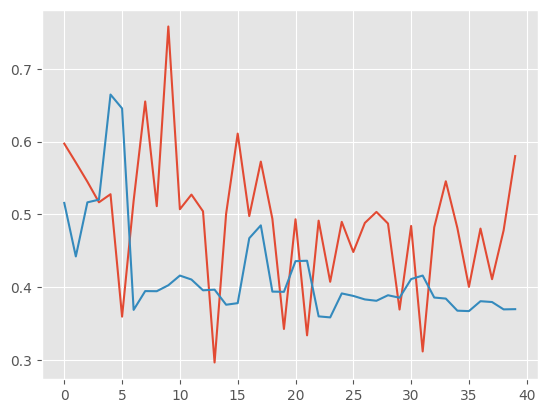

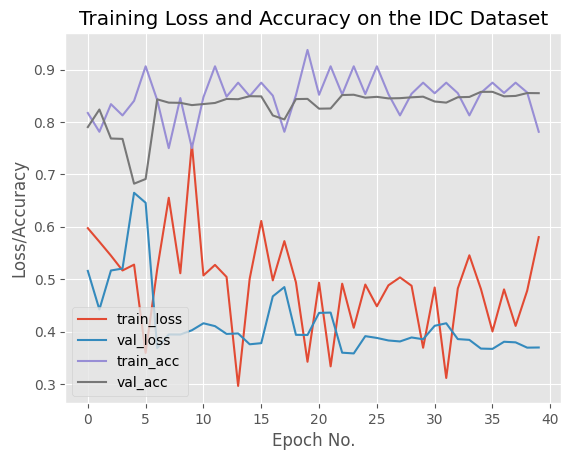

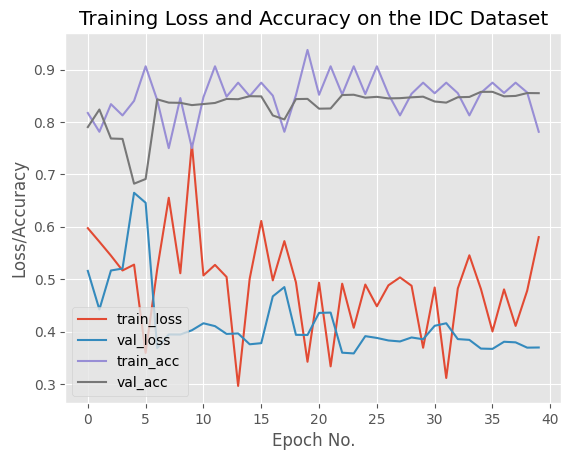

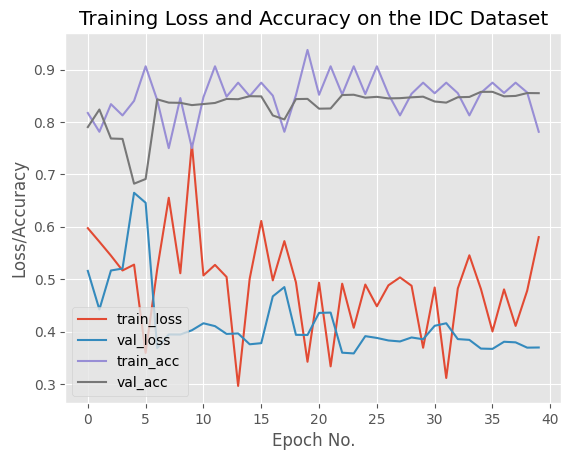

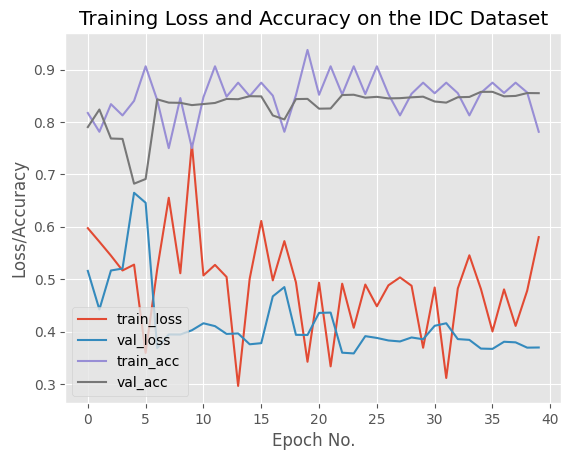

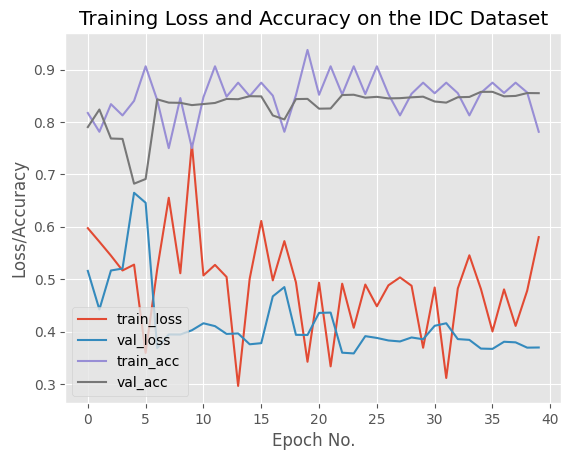

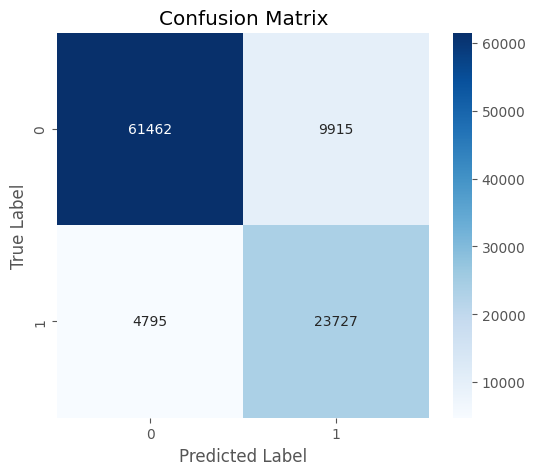

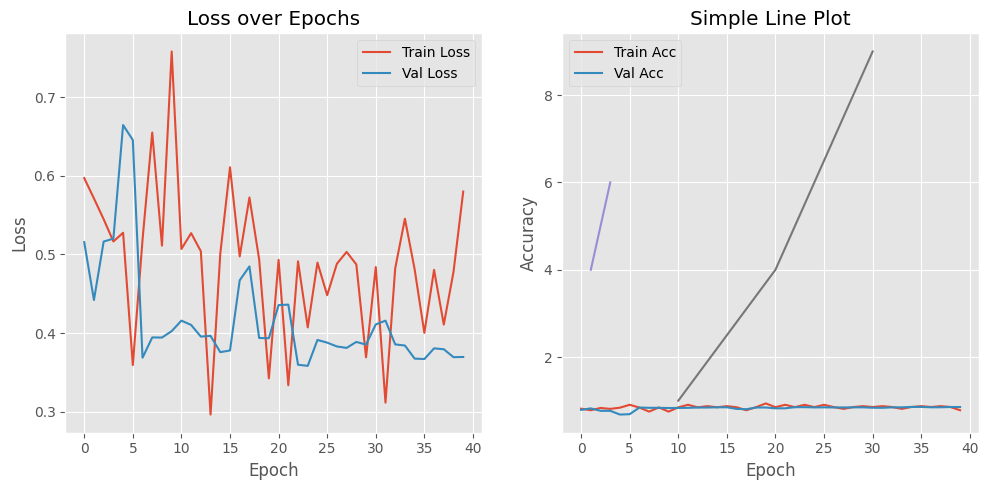

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot([10, 20, 30], [1, 4, 9])
plt.title("Simple Line Plot")
plt.show()


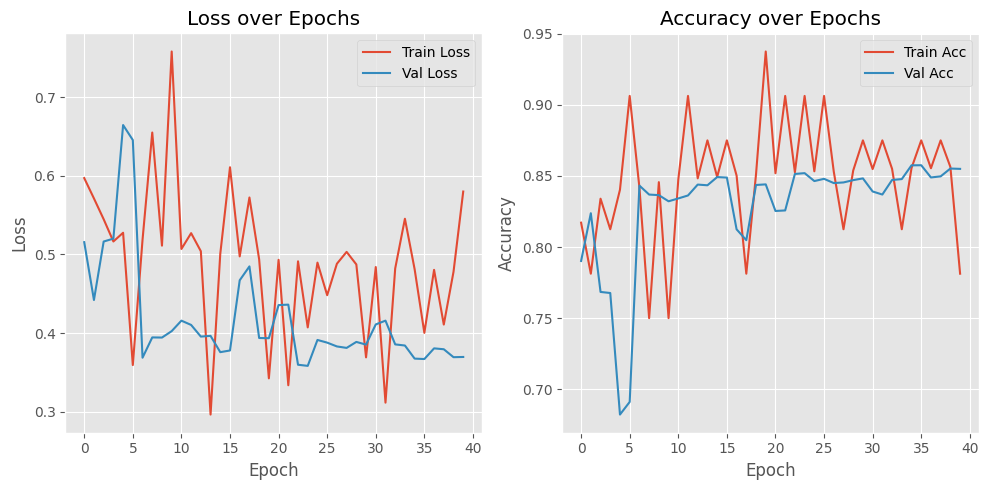

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Number of epochs
N = NUM_EPOCHS

plt.style.use("ggplot")
plt.figure(figsize=(10, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(np.arange(0, N), M.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), M.history["val_loss"], label="Val Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(np.arange(0, N), M.history["accuracy"], label="Train Acc")
plt.plot(np.arange(0, N), M.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()  # <== required to display in Colab


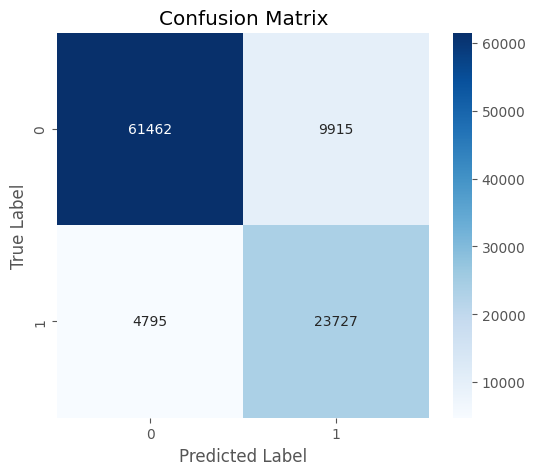

In [ ]:
import seaborn as sns

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=testGen.class_indices.keys(),
            yticklabels=testGen.class_indices.keys())

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig("confusion_matrix.png")
plt.show()


In [ ]:
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import numpy as np

# Assuming M is your model returned from model.fit(...)
N = len(M.history["loss"])

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), M.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), M.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), M.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), M.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on the IDC Dataset")
plt.xlabel("Epoch No.")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('plot.png')



In [ ]:
import matplotlib
# Remove or comment out the line below to allow inline plotting in notebooks
# matplotlib.use("Agg")
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,N), M.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), M.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), M.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,N), M.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on the IDC Dataset")
plt.xlabel("Epoch No.")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('plot.png')

# Add this line to explicitly show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
matplotlib.use("Agg")
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,N), M.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), M.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), M.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,N), M.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on the IDC Dataset")
plt.xlabel("Epoch No.")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('plot.png')

In [ ]:
from keras.callbacks import EarlyStopping, LearningRateScheduler


In [ ]:
def lr_schedule(epoch, lr):
    if epoch > 30:
        return lr * 0.5
    elif epoch > 20:
        return lr * 0.5
    return lr


In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',     # or 'val_accuracy'
    patience=5,             # wait 5 epochs before stopping
    restore_best_weights=True
)


In [ ]:
lrs = []

def lr_tracker(epoch, lr):
    lrs.append(lr)
    return lr

callbacks_list = [
    LearningRateScheduler(lr_tracker),
    early_stop
]


In [ ]:


M = model.fit(
    trainGen,
    steps_per_epoch=lenTrain // BS,
    validation_data=valGen,
    validation_steps=lenVal // BS,
    class_weight=classWeight,
    epochs=NUM_EPOCHS,
    callbacks=callbacks_list
)


Epoch 1/40
7988/7988 ━━━━━━━━━━━━━━━━━━━━ 371s 46ms/step - accuracy: 0.8556 - loss: 0.4833 - val_accuracy: 0.8343 - val_loss: 0.4023 - learning_rate: 0.0100
Epoch 2/40
   1/7988 ━━━━━━━━━━━━━━━━━━━━ 1:38 12ms/step - accuracy: 0.9688 - loss: 0.3935

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


7988/7988 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9688 - loss: 0.3935 - val_accuracy: 0.8348 - val_loss: 0.4009 - learning_rate: 0.0100
Epoch 3/40
7988/7988 ━━━━━━━━━━━━━━━━━━━━ 381s 48ms/step - accuracy: 0.8566 - loss: 0.4748 - val_accuracy: 0.8560 - val_loss: 0.3641 - learning_rate: 0.0100
Epoch 4/40
7988/7988 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.8750 - loss: 0.4232 - val_accuracy: 0.8564 - val_loss: 0.3641 - learning_rate: 0.0100
Epoch 5/40
7988/7988 ━━━━━━━━━━━━━━━━━━━━ 442s 50ms/step - accuracy: 0.8571 - loss: 0.4760 - val_accuracy: 0.8552 - val_loss: 0.3680 - learning_rate: 0.0100
Epoch 6/40
7988/7988 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.8438 - loss: 0.4034 - val_accuracy: 0.8554 - val_loss: 0.3680 - learning_rate: 0.0100
Epoch 7/40
7988/7988 ━━━━━━━━━━━━━━━━━━━━ 382s 48ms/step - accuracy: 0.8571 - loss: 0.4731 - val_accuracy: 0.8524 - val_loss: 0.3805 - learning_rate: 0.0100
Epoch 8/40
7988/7988 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9688 -

In [ ]:
# Training and validation loss & accuracy per epoch
train_loss = M.history['loss']
val_loss = M.history['val_loss']
train_acc = M.history.get('accuracy') or M.history.get('acc')
val_acc = M.history.get('val_accuracy') or M.history.get('val_acc')

print("Final Training Loss:", train_loss[-1])
print("Final Validation Loss:", val_loss[-1])
print("Final Training Accuracy:", train_acc[-1])
print("Final Validation Accuracy:", val_acc[-1])


Final Training Loss: 0.27196717262268066
Final Validation Loss: 0.380411297082901
Final Training Accuracy: 0.96875
Final Validation Accuracy: 0.8524436354637146


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Predict probabilities
y_pred_probs = model.predict(valGen, steps=lenVal // BS)
# Convert probabilities to class indices (for multi-class)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels from generator (assuming valGen has attribute `classes`)
y_true = valGen.classes[:len(y_pred)]

print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))


1330/1330 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step
              precision    recall  f1-score   support

           0       0.92      0.88      0.90     30492
           1       0.72      0.81      0.76     12068

    accuracy                           0.86     42560
   macro avg       0.82      0.84      0.83     42560
weighted avg       0.86      0.86      0.86     42560

[[26707  3785]
 [ 2342  9726]]


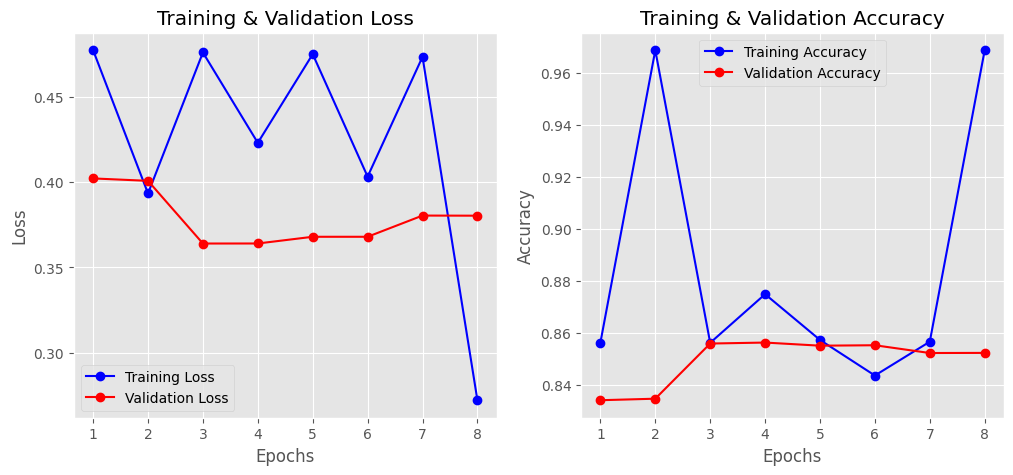

In [ ]:
import matplotlib.pyplot as plt

# Extract history
history = M.history

# Check if 'accuracy' or 'acc' key exists (depends on keras version)
acc = history.get('accuracy') or history.get('acc')
val_acc = history.get('val_accuracy') or history.get('val_acc')
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


1330/1330 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step
              precision    recall  f1-score   support

           0       0.92      0.88      0.90     30492
           1       0.72      0.81      0.76     12068

    accuracy                           0.86     42560
   macro avg       0.82      0.84      0.83     42560
weighted avg       0.86      0.86      0.86     42560



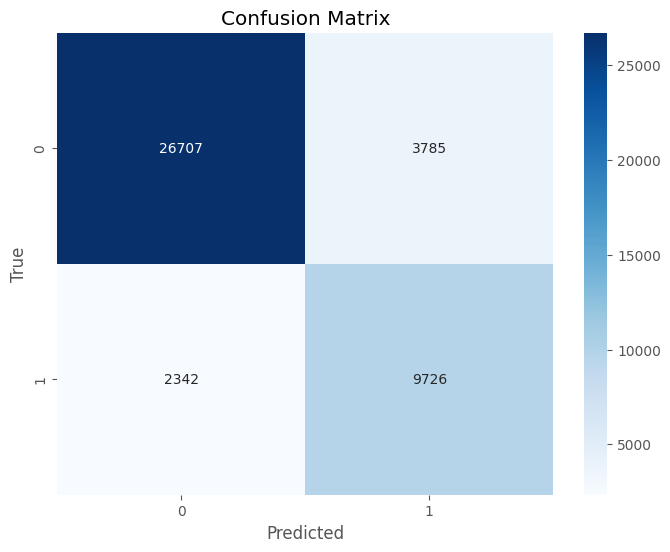

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict classes for validation set
y_pred_probs = model.predict(valGen, steps=lenVal // BS)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels (assumes valGen.classes contains true labels)
y_true = valGen.classes[:len(y_pred)]

# Classification report
print(classification_report(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
